# Case study. Making decisions based on A\B test results

## Statistical significance calculation
1. Calculating difference for conversion, AOV & ARPU for users in A\B test (test ID = 127)
2. Conclusions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

### About the data:
There are two tables

    1. ab_test_groups dataframe - contains data about users and test groups
    
    2. payments dataframe - contains data about customers payments
    
Key field = 'user_id'

In [2]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]

In [4]:
payments = pd.read_csv('payments.csv')
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [5]:
# Filtering data by date, convert column 'created_at' to string format. 
payments = payments.loc[(payments.created_at.astype(str) >= '2019-08-05')&
            (payments.created_at.astype(str) < '2019-08-12'), ['user_id', 'price']]
payments.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


In [6]:
payments = payments.groupby('user_id', as_index = False).agg({'price':'sum'})

In [7]:
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


In [8]:
ab_summary = ab_data.groupby('grp').agg({'user_id':'count', 'price':'count'}) # aggregate the data
ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'}, inplace = True) # rename columns
ab_summary

,users_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


In [9]:
ab_summary.loc[ab_summary.index == 'A', 'users_count'].sum()/ab_summary.users_count.sum()

0.4999282134280046

In [10]:
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
ab_summary

,users_count,buyers_count,conversion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


In [11]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), 
                 left_index = True, right_index = True) # Add conversion & AOV to the dataframe
ab_summary

,users_count,buyers_count,conversion,avg_bill
grp,,,,
A,76605,4279,0.055858,396.120589
B,76627,9427,0.123025,348.804498


In [12]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True) 
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
ab_summary['add_revenue'] = ab_summary.users_count*(ab_summary.ARPU - ab_summary.loc['A', 'ARPU'])
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,add_revenue
grp,,,,,,,
A,76605,4279,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


In [13]:
ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0), # conversion rate for group A
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0)  # conversion rate for group B
     ) 

(-46.38627328408593, 0.0)

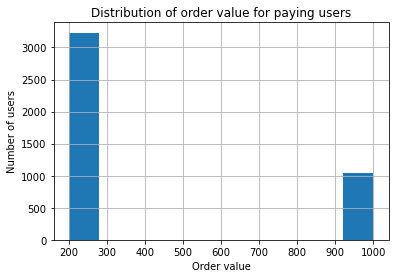

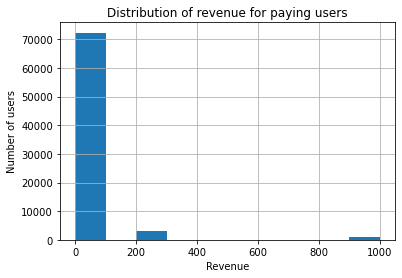

In [14]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Order value')
ax.set_ylabel('Number of users')
ax.set_title('Distribution of order value for paying users')
plt.show()

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Revenue')
ax.set_ylabel('Number of users')
ax.set_title('Distribution of revenue for paying users')
plt.show()

In [15]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna()),
stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=28984683.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


In [16]:
# Calculating confidence interval
def get_conf_interval(data, conf_level = 0.95):  
# confidence interval for mean 
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
# confidence interval for binary 
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [17]:
get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) 
# finding confidence interval for users in group A

0.8641428736438357

In [18]:
# confidence interval dictionary
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna())}
                 }

# Visualization of results in subplots 

In [19]:
def set_labels(axes):  
    y0, y1 = axes.get_ybound()  
    y_shift = 0.15* (y1 - y0)  

    for i, rect in enumerate(axes.patches):  
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
        y = height + y_shift * 0.8  
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [20]:
plot_summary = ab_summary.T 
# Transportated table 
significant_changes = ['conversion', 'avg_bill'] 
# Static value metrics

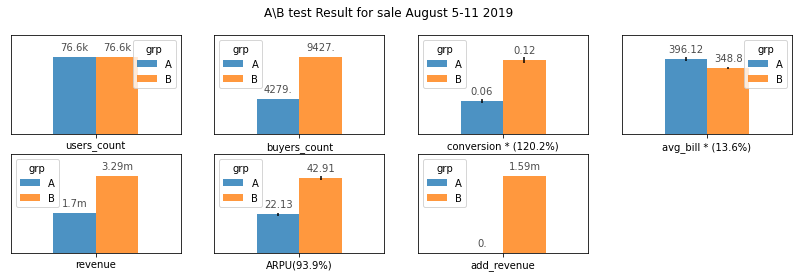

In [21]:
from matplotlib import gridspec
from math import ceil

ax = [] 
n_pict_in_line = 4 

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

# metric dynamic in percent
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "add_revenue" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('A\B test Result for sale August 5-11 2019' )

# Build graph
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
    # Adding subplots
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 

                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
    # Edit titles and subtitles 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

## Conclusions

* ARPU significantly increased by 93,9%.
* Conversion significantly increased by 120%.
* AOV significantly decreased by 13,6%.
* Additional revenue in В group is 1,59 million.

Sales and discounts boost a revenue instantly. It makes sense to do them from time to time.